In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least) #
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt
import xarray as xr

In [3]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [4]:
dir_acs = "/users/rsg/spa/spapapers/Pardo_Globlal_Chla/insitu/reprocessing/netCDF/Graban2020/"
fn_acs = "/TaraOceansPolarCircle.nc"

In [5]:
# read ACS (and HPLC) data in xr format
acs = xr.open_dataset(dir_acs + fn_acs)

# check keys
print(acs.keys())

#check attributes
acs['acs_chl'].attrs

# no of samples
print('No. of HPLC samples= ' + str(len(acs.hplc_time)))
print('No of ACS samples= ' + str(len(acs.time)))

KeysView(<xarray.Dataset>
Dimensions:         (time: 72281, hplc_time: 110, acs_wv: 176)
Coordinates:
  * time            (time) datetime64[ns] 2013-08-04T09:46:00 ... 2013-10-15T...
  * hplc_time       (hplc_time) datetime64[ns] 2013-08-04T06:33:00 ... 2013-1...
  * acs_wv          (acs_wv) float64 400.0 402.0 404.0 ... 746.0 748.0 750.0
Data variables:
    hplc_lat        (hplc_time) float64 ...
    hplc_lon        (hplc_time) float64 ...
    hplc_Tot_Chl_a  (hplc_time) float64 ...
    uway_lat        (time) float64 ...
    uway_lon        (time) float64 ...
    acs_chl         (time) float64 ...
    acs_ap          (time, acs_wv) float64 ...)
No. of HPLC samples= 110
No of ACS samples= 72281


['2013-08-04T09:46:00.000000000' '2013-08-04T09:47:00.000000000'
 '2013-08-04T09:48:00.000000000' ... '2013-10-15T18:18:00.000000000'
 '2013-10-15T18:19:00.000000000' '2013-10-15T18:20:00.000000000']


Text(0, 0.5, 'lon')

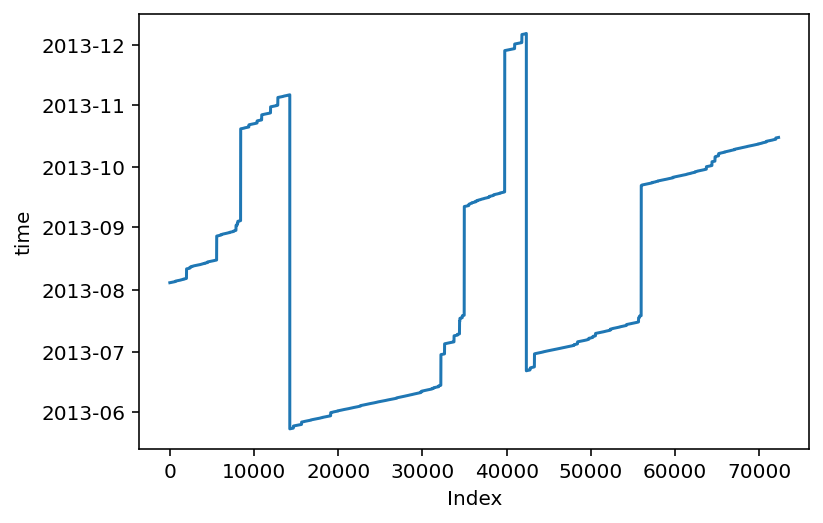

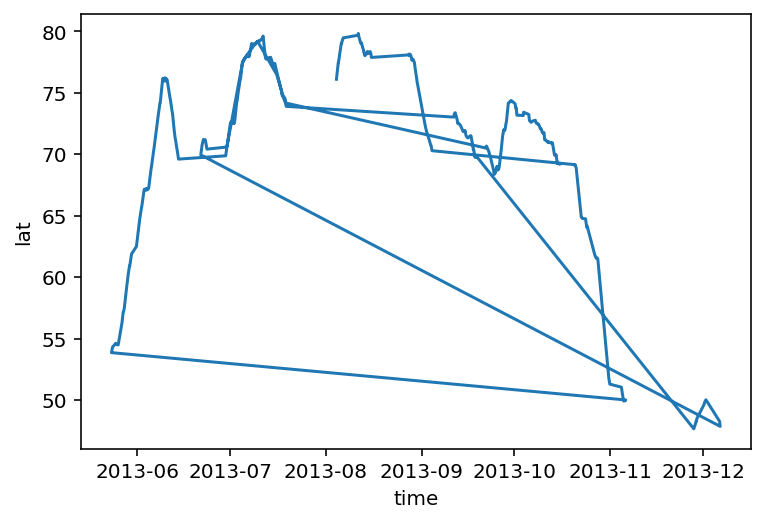

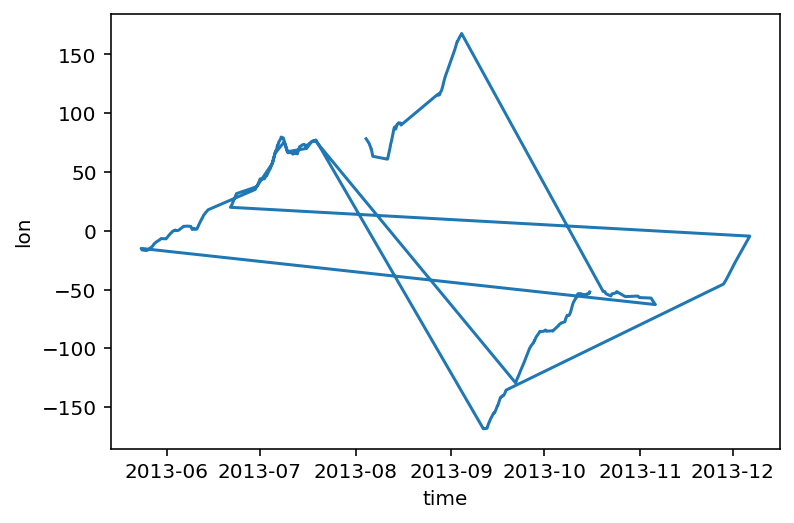

In [6]:
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)

plt.figure()
plt.plot(acs.time, acs.uway_lat)
plt.xlabel('time')
plt.ylabel('lat')

plt.figure()
plt.plot(acs.time, acs.uway_lon)
plt.xlabel('time')
plt.ylabel('lon')



['2013-05-23T15:10:00.000000000' '2013-05-23T15:11:00.000000000'
 '2013-05-23T15:12:00.000000000' ... '2013-12-06T12:48:00.000000000'
 '2013-12-06T12:49:00.000000000' '2013-12-06T12:50:00.000000000']
72281


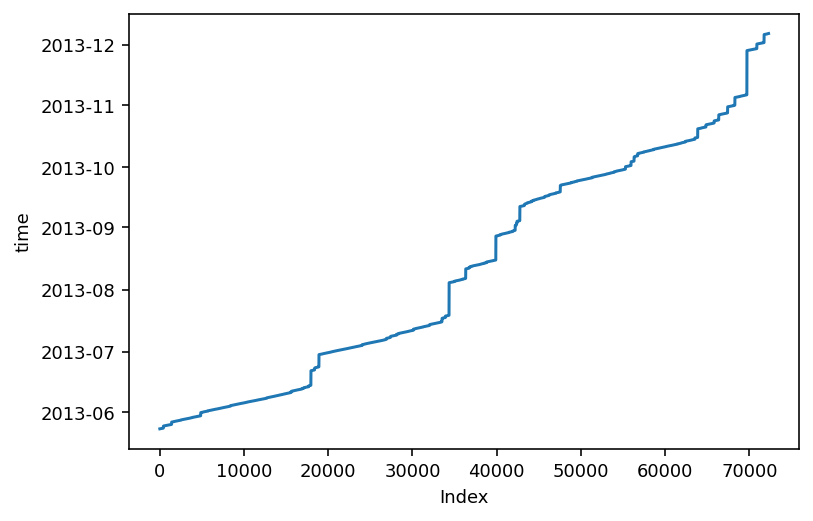

In [7]:

_, index = np.unique(acs['time'], return_index=True)
acs = acs.isel(time=index)
 
# check time, lat, lon
plt.rcParams.update({'font.size': 9})
    
plt.figure()
plt.plot(acs.time)
plt.xlabel('Index')
plt.ylabel('time')
print(acs.time.values)

print(len(acs.time.values))


In [8]:
# check temporal sample rate
plt.figure()
delta_t = np.median(np.diff(acs.time))
print(delta_t)
print(str(int(delta_t/10**9)) + ' secs')
# i

60000000000 nanoseconds
60 secs


<Figure size 432x288 with 0 Axes>

['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap']


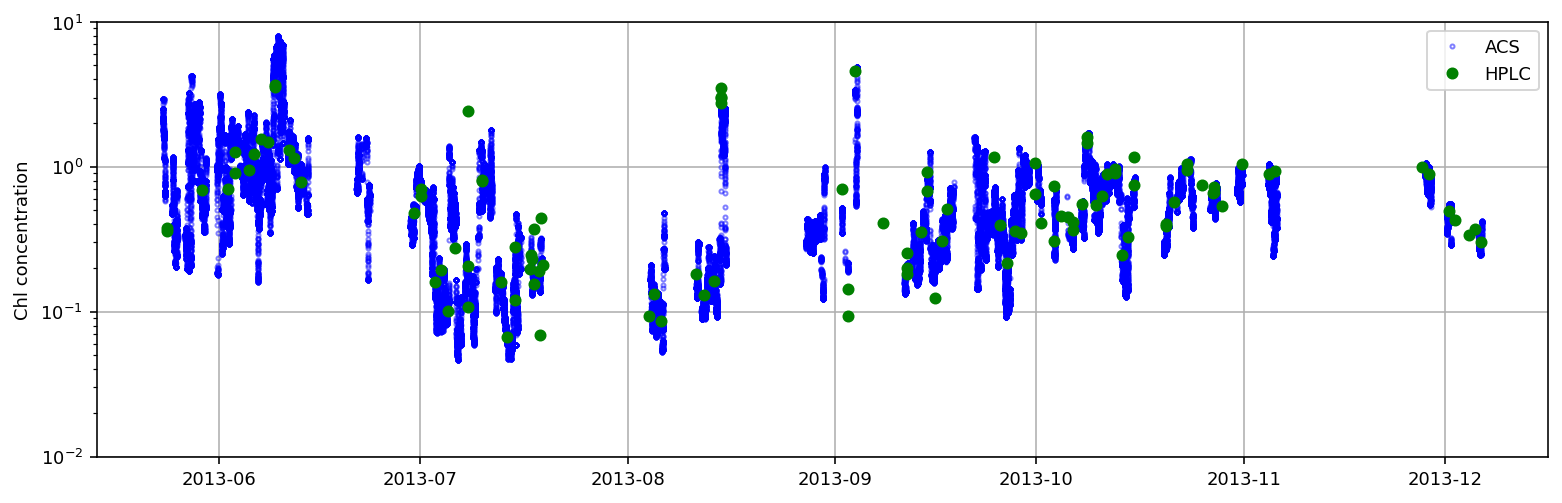

In [9]:
# Test plot of ACS(9) and HPLC Chl prior to match-up
# include emprical adjustment of AC9 chl using AMT
MEDFILT_WIN =31

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-2, 10])
plt.ylabel('Chl concentration')

#
print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1, label='HPLC')#, mfc='none')
#ax2.semilogy(acs.hplc_time + timedelta(days=1), acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1, label='HPLC')#, mfc='none')
# a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
# ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
# ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')
plt.legend()
#########




In [10]:
# maybe hplc lags by 1 day?
#for i in range(len(acs['hplc_time'])):
 #      acs['hplc_time'][i] = acs['hplc_time'][i] +  np.timedelta64(1,'D') 

72223
72223


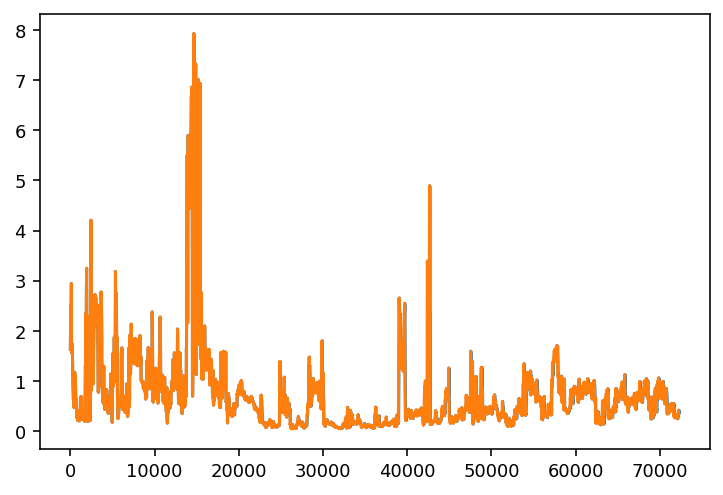

In [11]:
# step x - # median filter
plt.figure()
acs['acs_chl'].values = sg.medfilt(acs.acs_chl, kernel_size = MEDFILT_WIN) # apply med filter to acx chl and acx chl debiasesd 
plt.plot(acs['acs_chl'].values)

# step y  #filters w.r.t. ap(420) (10th element) being > 0
i2kp = np.where((acs.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs.time[i2kp], dims=['time']) 
acs_y = acs.sel(time = iy)
plt.plot(acs_y['acs_chl'].values)
print(len(acs_y['acs_chl'].values))

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_y.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_y.time[i2kp], dims=['time']) 
acs_z = acs_y.sel(time = iz)
print(len(acs_z['acs_chl'].values))



In [12]:
acs = []
acs = acs_z # redefine as filtered data structure

In [13]:
# match-ups #

# creat seriers objects
df_hplc = pd.Series(acs['hplc_Tot_Chl_a'].values,index = acs.hplc_time)
df_acs = pd.Series(acs['acs_chl'].values, index = acs.time)

# filter replicate hplcs
df_hplc = df_hplc.groupby(df_hplc.index).mean().reindex()

#
# creat seriers objects
df_hplc = pd.Series(acs['hplc_Tot_Chl_a'].values ,index = acs.hplc_time)
df_acs = pd.Series(acs['acs_chl'].values, index = acs.time)

# filter
df_hplc = df_hplc.groupby(df_hplc.index).mean() 
df_acs = df_acs.groupby(df_acs.index).mean() 

df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc, 'acs_chl': df_acs},index = df_hplc.index)
df_hplc_acs = df_hplc_acs.interpolate('index',limit=1).reindex(df_hplc_acs.index, method='nearest',tolerance='30min')
#df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc.index,method='nearest',tolerance='30min')

In [14]:
print(df_hplc.index)
print(df_hplc_acs)
# nans in acs_ch are where there are no match-ups

DatetimeIndex(['2013-05-24 07:27:00', '2013-05-29 11:48:00',
               '2013-06-02 07:02:00', '2013-06-03 09:29:00',
               '2013-06-05 12:36:00', '2013-06-06 06:12:00',
               '2013-06-07 07:16:00', '2013-06-08 07:15:00',
               '2013-06-09 09:09:00', '2013-06-11 12:48:00',
               '2013-06-12 06:10:00', '2013-06-13 07:11:00',
               '2013-06-30 04:47:00', '2013-07-01 04:52:00',
               '2013-07-03 05:30:00', '2013-07-04 04:01:00',
               '2013-07-05 04:16:00', '2013-07-06 04:11:00',
               '2013-07-08 04:00:00', '2013-07-10 07:24:00',
               '2013-07-13 01:57:00', '2013-07-14 01:57:00',
               '2013-07-15 03:44:00', '2013-07-17 08:58:00',
               '2013-07-17 14:04:00', '2013-07-17 18:45:00',
               '2013-07-18 01:08:00', '2013-07-18 17:40:00',
               '2013-07-18 22:20:00', '2013-07-19 01:11:00',
               '2013-07-19 08:24:00', '2013-08-04 06:33:00',
               '2013-08-

Linear metrics
-0.051542867756315114 0.369478628942248 67
Log metrics
0.05704487319776885 0.6347446314015455 67


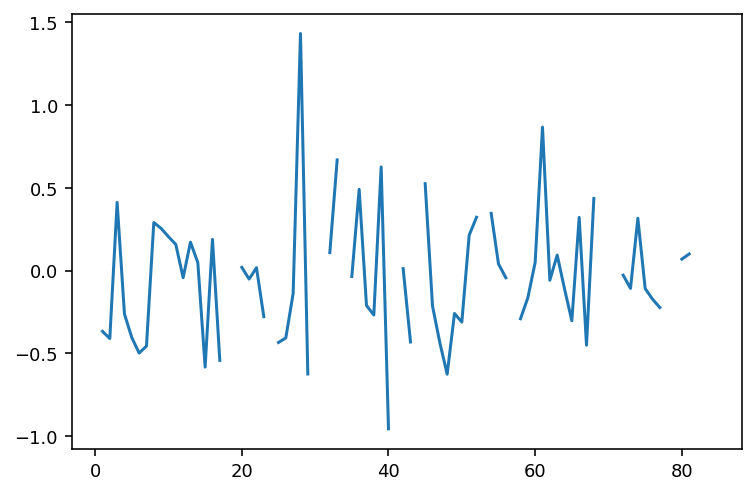

In [15]:
# compute residuals (lin and log space)
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1
rres_log = np.log10(df_hplc_acs.acs_chl.values)/ np.log10(df_hplc_acs.Tot_Chl_a.values) - 1

delta = np.nanmedian(rres)
delta_log = np.nanmedian(rres_log)
sigma = prcrng(rres)
sigma_log = prcrng(rres_log)
N = np.sum(~np.isnan(rres))
N_log = np.sum(~np.isnan(rres_log))

print('Linear metrics')
print(delta, sigma, N)

print('Log metrics')
print(delta_log, sigma_log, N)

plt.figure()
plt.plot(rres)


['hplc_lat', 'hplc_lon', 'hplc_Tot_Chl_a', 'uway_lat', 'uway_lon', 'acs_chl', 'acs_ap', 'acs_chl_debiased']


/tmp/ipykernel_586600/2504834762.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
/tmp/ipykernel_586600/2504834762.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')


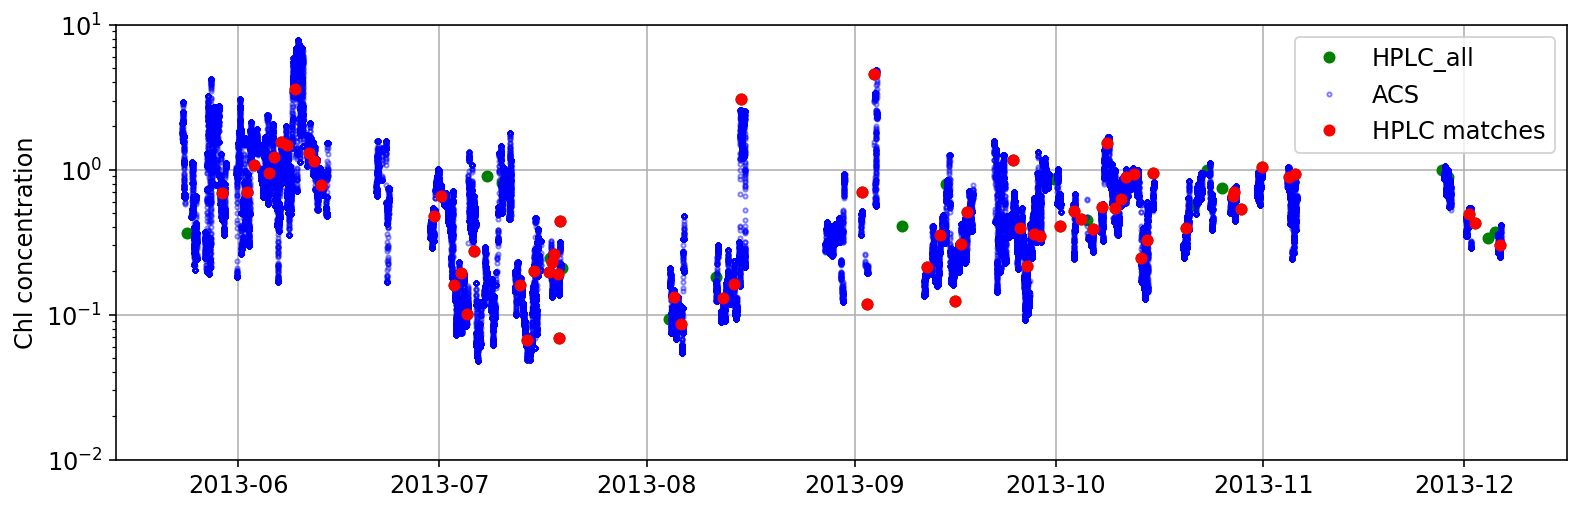

In [25]:
# Test plot of ACS(9) and HPLC Chl post match-up


MEDFILT_WIN = 31 # window length of med filter in minutes - note: this assumes data has been binned at 1 minute. 

#
fig2, ax2 = plt.subplots(1, figsize=(13, 4))
ax2.semilogy(df_hplc.index, df_hplc.values, 'go', ms=5, color='green', alpha=1, label='HPLC_all')#, mfc='none')
ax2.semilogy(acs.time, sg.medfilt(acs.acs_chl, kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=2, mfc='none', alpha = 0.5, label='ACS')
ax2.grid('on')
plt.legend()
plt.ylim([1e-2, 10])
plt.ylabel('Chl concentration')

print(list(acs.keys()))
ax2.semilogy(df_hplc_acs.index[~np.isnan(rres)==1], df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1], 'go', ms=5, color='red', alpha=1, label='HPLC matches')#, mfc='none')
plt.legend()
#########




[0.36725    0.6877     0.7028     1.0802     0.9437     1.2258
 1.5499     1.4743     3.6125     1.2931     1.1501     0.786
 0.4795     0.66205    0.1596     0.1936     0.1014     0.2754
 0.90913333 0.80465    0.1589     0.0673     0.19925    0.1972
 0.2443     0.2319     0.26225    0.191      0.0687     0.446
 0.2105     0.0936     0.1318     0.0859     0.183      0.1305
 0.1621     3.06545    0.7011     0.119      4.5564     0.4101
 0.21176667 0.3558     0.7998     0.1236     0.3063     0.5091
 1.1599     0.3944     0.2169     0.3621     0.351      0.85725
 0.4077     0.52005    0.4597     0.4489     0.3927     0.5523
 1.5251     0.5436     0.625      0.8896     0.9353     0.2461
 0.3275     0.9543     0.397      0.5705     0.99505    0.7492
 0.6561     0.6996     0.536      1.0386     0.8871     0.9358
 0.9903     0.8838     0.4959     0.4304     0.3363     0.374
 0.3028    ]


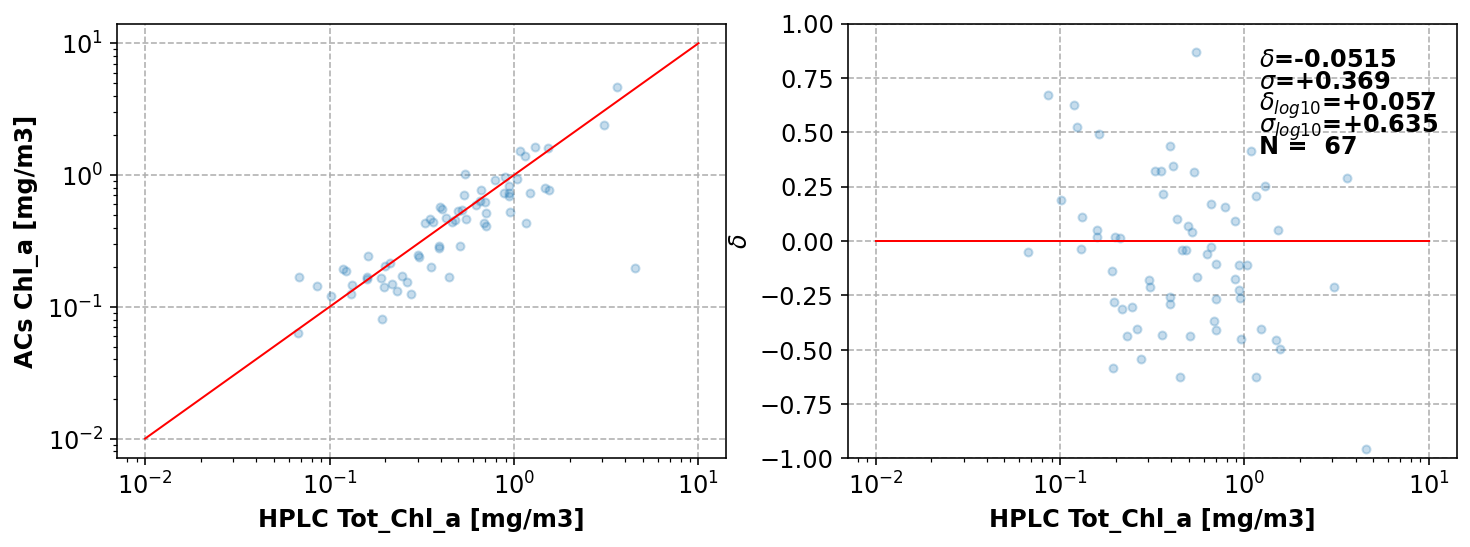

In [17]:

# scatter plots
plt.rcParams.update({'font.size': 12})
    
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('$\delta$', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(1.2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.7, r'$\sigma$='+f'{sigma:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.6, r'$\delta_{log10}$='+f'{delta_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.5, r'$\sigma_{log10}$='+f'{sigma_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.4, f'N = {N: 0}', fontweight='bold')




print(df_hplc_acs.Tot_Chl_a.values)



(-1.0, 1.0)

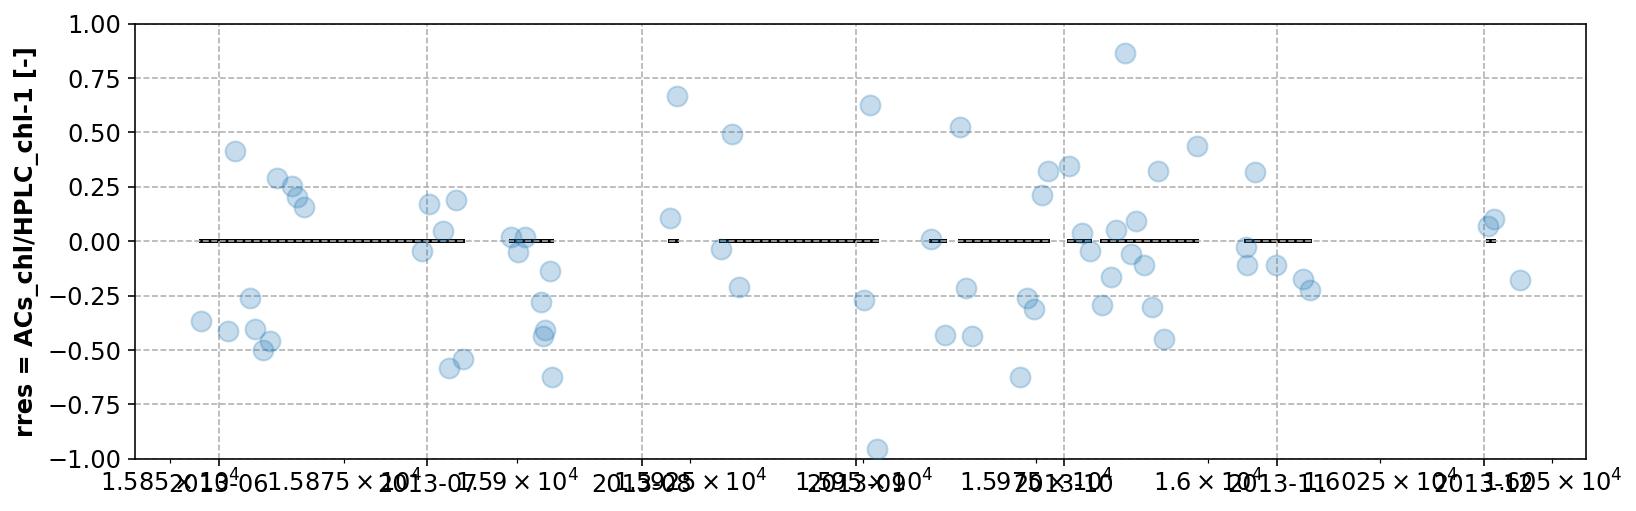

In [18]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [19]:
# Apply log transform prior to fitting power-law. Notation follows Brewin 2016. 
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*df_hplc_acs.acs_chl.values[~np.isnan(rres)==1]), np.log10(df_hplc_acs.Tot_Chl_a.values[~np.isnan(rres)==1]))

A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000

print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))
print('r_sq = ' + str(r_sq))

A = 42.65795188015925 +/- 2.9787221554218304
B = 0.871 +/- 0.15
r_sq = 0.672


In [20]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
# acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
#                              'lon [degE]': acs.uway_lon[i2f][innan],
#                             'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
#                           }  ,
# index = acs.time.values[i2f][innan])

In [21]:
# add attributes to acs_chl_debiased #
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a[~np.isnan(rres)==1].values  # filter nans
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs[~np.isnan(rres)==1].acs_chl.values # filter nans
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs[~np.isnan(rres)==1].index.format()

In [22]:

print(acs.acs_chl_debiased)
len(acs.acs_chl_debiased.attrs["match_up_dates"])
len(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])


<xarray.DataArray 'acs_chl_debiased' (time: 72223)>
array([1.71209476, 1.74637127, 1.81240322, ..., 0.40979343, 0.39720444,
       0.38332562])
Coordinates:
  * time     (time) datetime64[ns] 2013-05-23T15:10:00 ... 2013-12-06T12:50:00
Attributes:
    debiasing_equation:   acs.acs_chl_debiased = acs.acs_chl*(1-delta)
    delta:                -0.051542867756315114
    sigma:                0.369478628942248
    units:                mg/m3
    comments:             delta=np.nanmedian(rres), sigma=prcrng(rres), rres=...
    HPLC_Tot_chla:        [0.6877     0.7028     1.0802     0.9437     1.2258...
    HPLC_Tot_chla_units:  mg/m3
    acs_chl:              [0.43487054 0.41393852 1.5256625  0.6957393  0.7291...
    acs_chl_units:        mg/m3
    processed_on:         2023-12-06 13:43:44.467839
    match_up_dates:       ['2013-05-29 11:48:00', '2013-06-02 07:02:00', '201...


67

In [23]:
print('max/min conc range for results table')
print(np.min(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"]))
print(np.max(acs.acs_chl_debiased.attrs["HPLC_Tot_chla"])) # quote min max of match-ups 

max/min conc range for results table
0.0673
4.5564


In [24]:

# save updated NetCDF file
dir_acs_out = '/data/datasets/cruise_data/active/ACS_Chl/Glob_OC_matchups/Debiased_nc/'
acs.to_netcdf(dir_acs_out + fn_acs[:-3] + '_with_debiased_chl.nc')
acs.close()
